# Cylindrical Nanowire Hamiltonian Spectrum
In this notebook, I will investigate the Hamiltonian of a cylindrical nanowire SNS junction. Spin-orbit coupling and Zeeman term will be assumed to be present. 

Consider a nanowire placed longitudinally along the z-axis. A magnetic field $B_z$ is also assumed to be present along the z-axis.

$$ H_e = \frac{p_z^2 + p_\phi^2 + p_r^2}{2m} - \mu + \alpha (\vec{\sigma} \times \vec{p}) \cdot \hat{r} + \frac{1}{2} g \mu_B \hbar B_z \sigma_z $$

$\textbf{Update 4th May:
In the intial version of code in this document, the spin-orbit and Zeeman terms will be dropped.}$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools

In [12]:
# create the Hamiltonian matrix

def calc_hamiltonian(params):
    '''
    Returns the Hamiltonian in the real space basis.
    params is a dict with the following information:
        N_z : number of points along z
        N_phi : number of points along azimuthal direction
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
    '''
    N_z = params['N_z']
    N_phi = params['N_phi']
    t_z = params['t_z']
    t_phi = params['t_phi']
    mu = params['mu']
    flux = params['flux']
    Delta = params['Delta']
    
    def calc_matrix_element(x,y):
        '''
        Returns the matrix element between two real space points x and y
        '''
        (z1,phi1) = x
        (z2,phi2) = y
        # onsite element
        if z1 == z2 and phi1 == phi2:
            if N_phi != 1:
                diag_ele = 2*t_z + np.abs(t_phi)*(2 - (2*np.pi*flux/N_phi)**2) - mu
            else:
                # diagonal elemenet for N_phi = 1 does not make sense
                diag_ele = 2*t_z - mu
            return np.array([[diag_ele,Delta],[np.conj(Delta),-diag_ele ]])
        # z hopping
        elif abs(z1-z2) == 1 and phi1 == phi2:
            return np.array([[t_z,0],[0,-t_z]])
        # phi hopping
        elif (phi1-phi2 == 1 or phi1-phi2 == N_phi-1)and z1 == z2:
            return np.array([[-t_phi,0],[0,np.conj(t_phi)]])
        elif (phi1-phi2 == -1 or phi1-phi2 == -N_phi+1)and z1 == z2:
            return np.conj(np.array([[-t_phi,0],[0,np.conj(t_phi)]])).T
        else:
            return np.array([[0,0],[0,0]])
    
    basis = list(itertools.product(range(N_z),range(N_phi)))
    H_list = [calc_matrix_element(x,y) for x in basis for y in basis]
    N = N_phi*N_z
    H = np.array(H_list).reshape((N,N,2,2))
    
    # magic to flatten the Hamiltonian
    # Are you wathing closely?
    H = np.array([H[x,:,y,:].flatten() for x in range(H.shape[0]) for y in range(H.shape[2])])\
    .flatten().reshape(2*N,2*N)
    
    return H
    

In [14]:
# test of the Hamiltonian function
params = {
    "N_z" : 2,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 5e-3,
    "Delta" : 1e-3,
    "mu" : 0e-3,
}

params["t_phi"] = 1e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])

H = calc_hamiltonian(params)
print(H,H.shape)

[[ 0.01   0.001  0.005  0.   ]
 [ 0.001 -0.01   0.    -0.005]
 [ 0.005  0.     0.01   0.001]
 [ 0.    -0.005  0.001 -0.01 ]] (4, 4)


In [18]:
# surface Green's funciton routines
# ordinary iteration schemes will be used

def calc_surface_g(E,alpha,beta,eta,eps = 1e-8,max_iter=100000,kappa=0.5):
    '''
    Return the surface Green's function at energy E 
   
    eta is used to calculated the Green's function
    eps controls the accuracy
    
    Returns the surface Green's function as a solution of the recursive relation 
    g = ((E + 1j*eta) - alpha - beta'*g*beta)^-1
    '''
    # conv here to avoid problems later
    E = np.array(E)
    
    
    def func_g(g,E,alpha,beta,eta):
        return np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(alpha.shape[0])- alpha - beta @ g @ np.conj(beta).T)
   
    g0 = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    g = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    
    err_vec = []
    for i in range(max_iter):
        g = func_g(g,E,alpha,beta,eta)
        g = ((1-kappa)*g + kappa*g0)
        err = np.linalg.norm(g - g0)/len(E)
        err_vec.append(err)
        g0 = np.copy(g)
        if err < eps:
            break
    return g

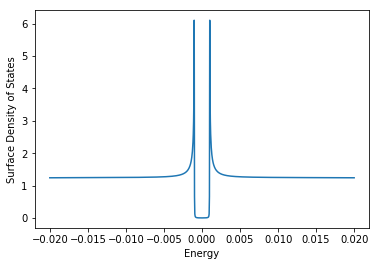

In [42]:
# testing the surface_g code
# test of the Hamiltonian function
params = {
    "N_z" : 10,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 1000e-3,
    "Delta" : 1e-3,
    "mu" : 100e-3,
}

params["t_phi"] = 0e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])


H = calc_hamiltonian(params)
surface_dof = 2*params['N_phi']
alpha = H[:surface_dof,:surface_dof]
beta = H[:surface_dof,surface_dof:2*surface_dof]

E = np.linspace(-20e-3,20e-3,1000)
eta = 0.1*np.abs(E[1]-E[0])
g = calc_surface_g(E,alpha,beta,eta)
a = 1j*(g - np.conj(np.transpose(g,(0,2,1))))
dos = np.real(np.trace(a,axis1=-1,axis2=-2))

plt.plot(E,dos)
plt.xlabel("Energy")
plt.ylabel("Surface Density of States")

In [23]:
def calc_sns_negf(params):
    '''
    Returns the G,A,Sigma matrices for SNS device. The chemical potential will be assumed to same everywhere and
    no bias is present across the device.
    params dict takes in these parameters:
        N_z : number of points along z in the normal region
        N_phi : number of points along azimuthal direction
        t_z : h^2/(2 m a^2), where a is lattice spacing
        t_phi : h^2/(2 m R^2), where a is lattice spacing
        mu : chemical potential
        Delta_1 : superconducting parameter 1
        Delta_2 : superconducting parameter 2
        eta : imaginary 0+ added for convergence
    '''
    N_z = params['N_z']
    N_phi = params['N_phi']
    t_z = params['t_z']
    t_phi = params['t_phi']
    Delta_1 = params['Delta_1']
    Delta_2 = params['Delta_2']
    mu = params['mu']
    eta = params['eta']
    
    # create alpha/beta hamiltonians for S regions
    # calc surface Green's function
   
    params_S1 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z,"N_phi" : N_phi, "Delta" : Delta_1, " mu" : mu,"flux" : flux}
    H_S1 = calc_hamiltonian(params_S1)   
    surface_dof = 2*N_phi
    alpha_1 = H_S1[:surface_dof,:surface_dof]
    beta_1 = H_S1[:surface_dof,surface_dof:2*surface_dof]
    g_1 = calc_surface_g(E,alpha_1,beta_1,eta)
    
    params_S2 = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z,"N_phi" : N_phi, "Delta" : Delta_2, " mu" : mu,"flux" : flux}
    H_S2 = calc_hamiltonian(params_S2)   
    surface_dof = 2*N_phi
    alpha_2 = H_S2[:surface_dof,:surface_dof]
    beta_2 = H_S2[:surface_dof,surface_dof:2*surface_dof]
    g_2 = calc_surface_g(E,alpha_2,beta_2,eta)
    
    
    # create Hamiltonian for N region
    params_N = {'t_z' : t_z,'t_phi' : t_phi,'N_z' : N_z,"N_phi" : N_phi, "Delta" : 0, " mu" : mu,"flux" : flux}
    H_mat = calc_hamiltonian(params_N)
    
    #number of dof in a layer
    N_dof_lat = N_phi*2
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    # the only non-zero elements in sigma
    sigma_mini_1 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_1@beta_layer
    sigma_mini_2 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_2@beta_layer
    
    sigma_1 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_1[:,:N_dof_lat,:N_dof_lat] = sigma_mini_1
    
    sigma_2 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_2[:,-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
    
    # NEGF matrices
    G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)
    
    A = 1j*(G - np.transpose(np.conj(G),(0,2,1))) 
    dos = np.real(np.trace(A,axis1=-2,axis=-1))
    
    return G,A,dos

In [ ]:
# testing the dos code
params = {
    "N_z" : 2,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 5e-3,
    "Delta" : 1e-3,
    "mu" : 0e-3,
}

params["t_phi"] = 1e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])

# Notes
 - I am unsure how to incorporate the flux term in the diagonal element.
 
 
 Next step: Look at the spectrum!

# Intersting Asides
1. Visualisation of surface density of states in $\mu$-$\Delta$ space. 

In [ ]:
params = {
    "N_z" : 10,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 1000e-3,
    "Delta" : 1e-3,
    "mu" : 100e-3,
}

params["t_phi"] = 0e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])

E = np.linspace(-10e-3,10e-3,1000)
eta = 0.1*np.abs(E[1]-E[0])

mu_vec = np.linspace(0,100e-3,25) 
data = []
for mu in mu_vec:
    params['mu'] = mu
    
    H = calc_hamiltonian(params)
    surface_dof = 2*params['N_phi']
    alpha = H[:surface_dof,:surface_dof]
    beta = H[:surface_dof,surface_dof:2*surface_dof]
    
    g = calc_surface_g(E,alpha,beta,eta)
    a = 1j*(g - np.conj(np.transpose(g,(0,2,1))))
    dos = np.real(np.trace(a,axis1=-1,axis2=-2))

    data.append(dos)
data = np.array(data)

In [ ]:
XX,YY = np.meshgrid(E,mu_vec)
plt.pcolor(XX,YY,data)
plt.xlabel("Energy")
plt.ylabel("Chemical potential")